<p style="font-size:36px;text-align:center"> <b>APS Component failure prediction</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Data Source: https://ida2016.blogs.dsv.su.se/?page_id=1387 </p>
<p> Data: Scania Trucks</p>

<h6> Problem statement : </h6>
<p>The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.</p>
<p> The prbolem is to reduce the cost due to unecessary repairs. So it is required to minimize the false predictions.</p>

Predicted class |	True class      |
                |   pos    |   neg  |
_____________________________________
        pos     |          | cost_1 |
_____________________________________
        neg     | cost_2   |        |
_____________________________________
 
Cost_1 = 10 and cost_2 = 500

<p>The total cost of a prediction model the sum of "Cost_1" 
multiplied by the number of Instances with type 1 failure 
and "Cost_2" with the number of instances with type 2 failure, 
resulting in a "Total_cost".

In this case Cost_1 refers to the cost that an unnessecary 
check needs to be done by an mechanic at an workshop, while 
Cost_2 refer to the cost of missing a faulty truck, 
which may cause a breakdown.

Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.</p>

* from the above problem statement we could observe that, we have to reduce false positives and false negatives.
* More importantly we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives. 

<h2>1.2. Key performance metric</h2>

* Here we have to reduce False Negative and False Positive, so clearly we can use precision and recall as performance metric.


<img src='precision and recall.png' width=700px>

* But here is a simpler metric which takes into account both precision and recall, and therefore, we can aim to maximize this number to make your model better. This metric is known as F1-score, which is simply the harmonic mean of precision and recall.

<img src='f1_score.png' width=500px>

#### Generally f1 score balance the precision and recall  but one simple idea is that, because of cost incurred due to false negative is 50 times higher than the false positives, for this specific problem if we could try to slightly increase recall we may get better results .

###### we should decrease false negatives in such a way that one point decrease in FN can be accepted for the cost of 49 FP. Since 1 point cost of FN = 50 point cost of FP

<h2>1.3. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is not important.
* misclassification leads the unecessary repair costs.

<h1>2. Machine Learning Problem Formulation</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
import missingno as msno
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
warnings.filterwarnings("ignore")

## Data Loading and preprocessing

In [2]:
train = pd.read_csv("aps_failure_training_set.csv")
test = pd.read_csv("aps_failure_test_set.csv")

In [3]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [4]:
test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [5]:
print("shape of train dataset:",train.shape)
print("shape of test dataset:",test.shape)

shape of train dataset: (60000, 171)
shape of test dataset: (16000, 171)


In [6]:
train["class"].unique()

array(['neg', 'pos'], dtype=object)

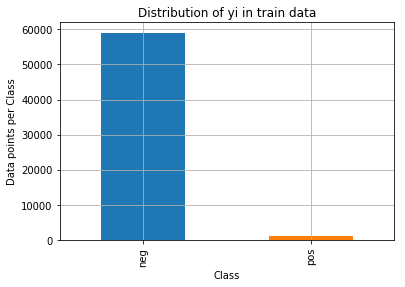

In [7]:
train_class_distribution = train['class'].value_counts()
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

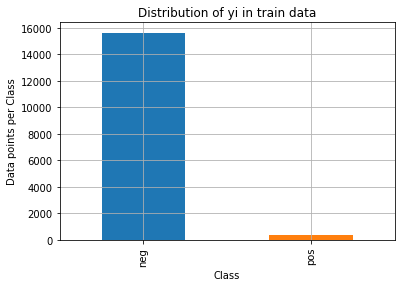

In [8]:
train_class_distribution = test['class'].value_counts()
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

#### Observation:
* from above Bar Plots, we could conclude that the given data is highly imbalanced

In [9]:
train.replace(to_replace = 'neg', value = 0, inplace = True)
train.replace(to_replace = 'pos', value = 1, inplace = True)
test.replace(to_replace = 'neg', value = 0, inplace = True)
test.replace(to_replace = 'pos', value = 1, inplace = True)

In [10]:
y_train = train["class"]
train.drop(['class'],axis = 1,inplace = True)
y_test = test["class"]
test.drop(['class'],axis = 1,inplace = True)

### Checking for Missing Values

In [11]:
# In the given data missing values are represented as "na", but we require in the 
# np.NaN format to process the data

train.replace(to_replace = 'na', value = np.NaN, inplace = True)
test.replace(to_replace = 'na', value = np.NaN, inplace = True)

In [12]:
train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,NaN,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,NaN,0,NaN,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,NaN,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,0,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,60874,NaN,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


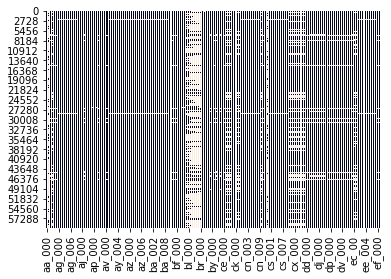

In [13]:
#https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj
sns.heatmap(train.isnull(), cbar=False)

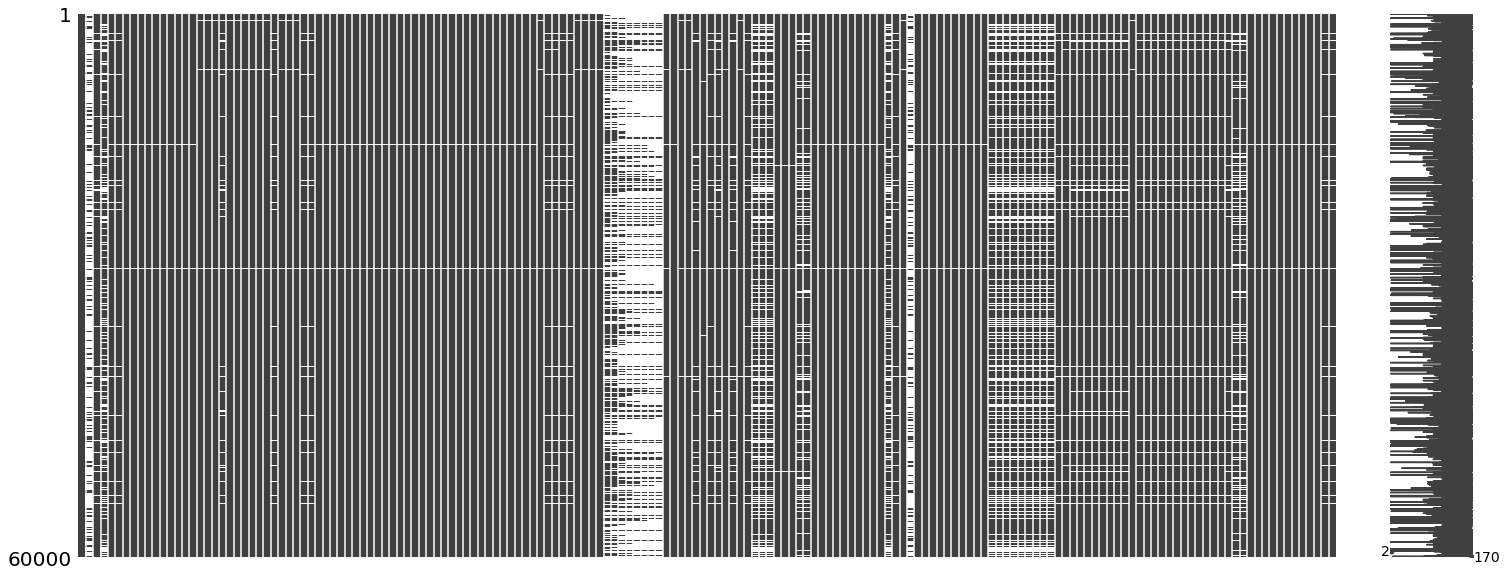

In [14]:
msno.matrix(train)

#### Oservations:
* There are lot of missing values in the data, so we cannot remove the rows as it will leads to the great amount of information loss.
* To avoid the information loss we will implement below two ideas to deal with the missing values.
    * Remove columns which contains more than 75% of NaN values.
    * Imputation techniques

In [15]:
# 75% of 60000 = 45000
train.dropna(axis = 1, thresh=45000,inplace= True)

In [16]:
new_columns = train.columns

In [17]:
# Finding removed columns
removed_columns = []
for i in test.columns:
    if i not in new_columns:
        removed_columns.append(i)

In [18]:
# Dropping removed columns of train data from test data
test.drop(removed_columns,axis = 1,inplace = True)

In [19]:
test.shape

(16000, 160)

### Imputation Techniques

* popular Imputation Techniques are:
    * Mean Imputation
    * Median Imputation
    * constant value imputation
    * Most_frequent value imputation
*  Most_frequent value imputation will work fairly well on categorical data. Since our data is continuous we will focus on first 3 methods.

#### Mean Imputation

In [20]:
mean_imputation = SimpleImputer(missing_values= np.nan , strategy="mean")
x_train_mean = mean_imputation.fit_transform(train)
x_test_mean = mean_imputation.transform(test)

#### Median Imputation

In [21]:
median_imputation = SimpleImputer(missing_values= np.nan , strategy="median")
x_train_median = median_imputation.fit_transform(train)
x_test_median = median_imputation.transform(test)

#### constant value imputation

In [22]:
constant_imputation = SimpleImputer(missing_values= np.nan,strategy='constant', fill_value=-1)
x_train_constant = constant_imputation.fit_transform(train)
x_test_constant = constant_imputation.transform(test)

### Balancing the data using SMOTE(Synthetic Minority Oversampling Technique)

* SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

###### SMOTE for mean Imputed data

In [23]:
sm = SMOTE(random_state=2)
X_train_mean_sm, y_train_mean = sm.fit_sample(x_train_mean, y_train.ravel())

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Standardizing the data
ss = StandardScaler()
X_train_mean_std = ss.fit_transform(X_train_mean_sm)
X_test_mean_std = ss.transform(x_test_mean)

###### SMOTE for median Imputed data

In [26]:
sm = SMOTE(random_state=2)
X_train_median_sm, y_train_median = sm.fit_sample(x_train_median, y_train.ravel())

In [27]:
ss = StandardScaler()
X_train_median_std = ss.fit_transform(X_train_median_sm)
X_test_median_std = ss.transform(x_test_median)

###### SMOTE for constant value Imputed data

In [28]:
sm = SMOTE(random_state=2)
X_train_con_sm, y_train_constant = sm.fit_sample(x_train_constant, y_train.ravel())

In [29]:
ss = StandardScaler()
X_train_constant_std = ss.fit_transform(X_train_con_sm)
X_test_constant_std = ss.transform(x_test_constant)

# Utility Functions

In [30]:
def plot_confusion_matrix(test_y, predict_y):
    
    '''
    This function takes y_ture, y_predicted, and prints consfusion matrix,
    f1_score and Total cost due to misclassification
        
    '''
    C = confusion_matrix(test_y, predict_y)
    
    plt.figure(figsize=(8,4))
    
    labels = ["neg","pos"]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix") 
    
    plt.show()
    cost_1 = 10*C[0][1]
    cost_2 = 500*C[1][0]
    total_cost = cost_1 + cost_2
    print("f1_score :",f1_score(test_y, predict_y))
    print("Total Cost due to mis classifiation:",total_cost)
    

In [31]:
def total_cost(test_y, predict_y):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    C = confusion_matrix(test_y, predict_y)
    cost_1 = 10*C[0][1]
    cost_2 = 500*C[1][0]
    total = (cost_1 + cost_2)
    return total

In [32]:
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
        Gives the plot of precision and recall vs thresholds
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [59]:
def pred_with_threshold(sig_clf_probs,t):
    '''
    This function takes proability scores and threshold value and classifies predictions based on threshold value
    
    '''
    

    predictions = []
    for i in sig_clf_probs:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## Random Model

In [34]:
import random

f1_score on Test Data using Random Model 0.04289799809342231


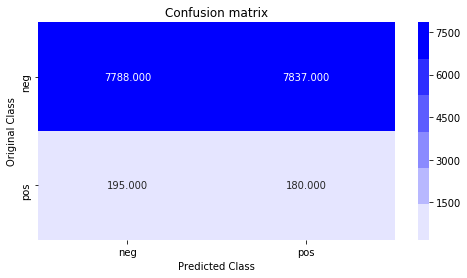

f1_score : 0.04289799809342231
Total Cost due to mis classifiation: 175870


In [35]:
test_len = X_test_mean_std.shape[0]
predicted_y = np.zeros((test_len))
for i in range(test_len):
    predicted_y[i] =random.randint(0,1)
print("f1_score on Test Data using Random Model",f1_score(y_test, predicted_y))

plot_confusion_matrix(y_test, predicted_y)

* with simple Random model we got f1_score as 0.047 and cost as 1,71,090. This would be the benchmark for our models

 <h2>4.3. svm with mean</h2>

In [ ]:
parameters = {"C": [10 ** x for x in range(-6, 3)]}

#Gridsearch CV with 8 fold crossvalidation

svc = SVC()    
GCV = GridSearchCV(svc,param_grid=parameters, scoring = "f1", verbose = 1,cv=8, n_jobs = -1)
GCV.fit(X_train_mean_std , y_train_mean )

Fitting 8 folds for each of 9 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [63]:
clf= GCV.best_estimator_

In [64]:
GCV.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

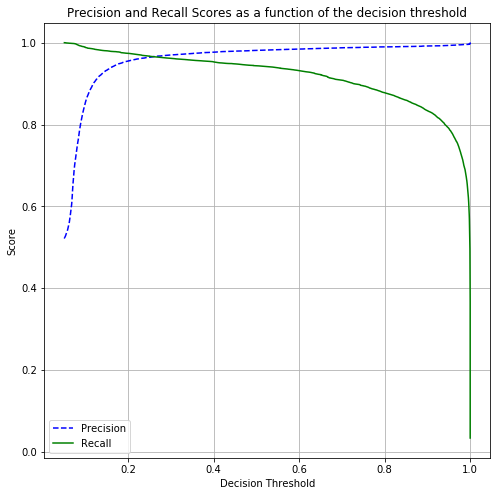

In [68]:
x_t, x_c, y_t, y_c = train_test_split(X_train_mean_std , y_train_mean, stratify=y_train_mean, test_size=0.3)
clf.fit(x_t, y_t)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_t, y_t)
sig_clf_probs = sig_clf.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [69]:
t=0.25

In [70]:
clf= GCV.best_estimator_
clf.fit(X_train_mean_std , y_train_mean)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_mean_std , y_train_mean)
test_clf_probs = sig_clf.predict_proba(X_test_mean_std)[:,1]
train_clf_probs = sig_clf.predict_proba(X_train_mean_std)[:,1]

In [71]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


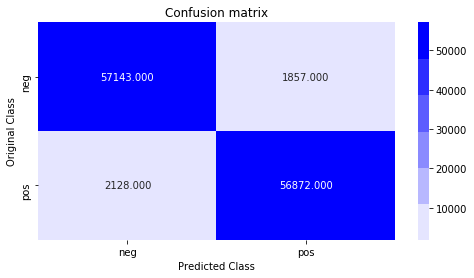

f1_score : 0.9661510757757221
Total Cost due to mis classifiation: 1082570
Test Confusion Matrix


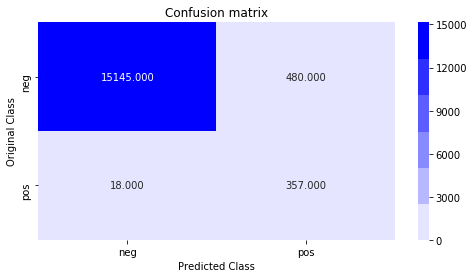

f1_score : 0.5891089108910891
Total Cost due to mis classifiation: 13800


In [72]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_mean, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

 <h2>4.3. Linear\logistic Regression with mean</h2>

In [62]:
parameters = {"alpha": [10 ** x for x in range(-6, 3)], "penalty" : ['l2','l1'], "loss" : ['log','hinge']}

#Gridsearch CV with 8 fold crossvalidation

LR = SGDClassifier()    
GCV = GridSearchCV(LR,param_grid=parameters, scoring = "f1", verbose = 1,cv=8, n_jobs = -1)
GCV.fit(X_train_mean_std , y_train_mean )

Fitting 8 folds for each of 36 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.2min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2', 'l1'], 'loss': ['log', 'hinge']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [63]:
clf= GCV.best_estimator_

In [64]:
GCV.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

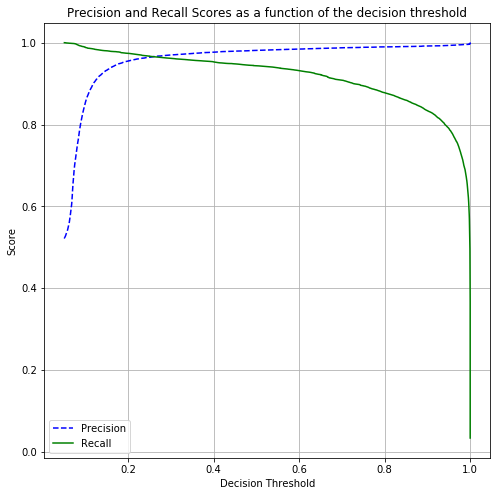

In [68]:
x_t, x_c, y_t, y_c = train_test_split(X_train_mean_std , y_train_mean, stratify=y_train_mean, test_size=0.3)
clf.fit(x_t, y_t)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_t, y_t)
sig_clf_probs = sig_clf.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [69]:
t=0.25

In [70]:
clf= GCV.best_estimator_
clf.fit(X_train_mean_std , y_train_mean)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_mean_std , y_train_mean)
test_clf_probs = sig_clf.predict_proba(X_test_mean_std)[:,1]
train_clf_probs = sig_clf.predict_proba(X_train_mean_std)[:,1]

In [71]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


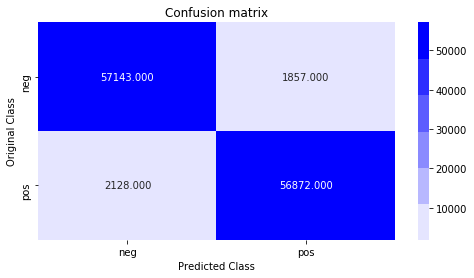

f1_score : 0.9661510757757221
Total Cost due to mis classifiation: 1082570
Test Confusion Matrix


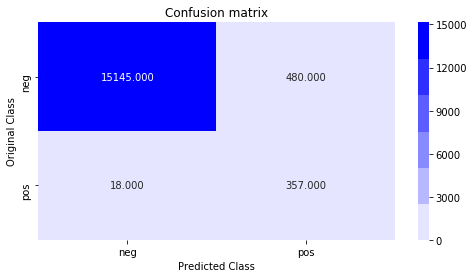

f1_score : 0.5891089108910891
Total Cost due to mis classifiation: 13800


In [72]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_mean, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

### XGB with mean

In [38]:
parameters = {"max_depth": [5,8,10] , "n_estimators":[300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

xgb = XGBClassifier()
GCV = GridSearchCV(xgb,param_grid=parameters, scoring = "f1", verbose = 1,cv=2, n_jobs = -1)
GCV.fit(X_train_mean_std , y_train_mean)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 128.1min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10],
                         'n_estimators': [300, 500, 1000, 2000]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [39]:
clf_xgb_mean= GCV.best_estimator_

In [40]:
GCV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

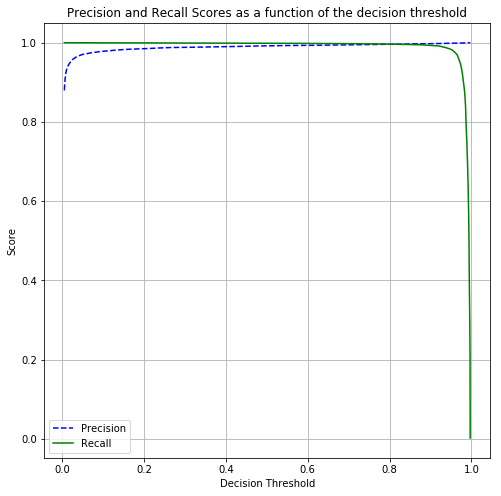

In [42]:
x_t, x_c, y_t, y_c = train_test_split(X_train_mean_std, y_train_mean, stratify=y_train_mean, test_size=0.3)
clf_xgb_mean.fit(x_t, y_t)
sig_clf_probs = clf_xgb_mean.predict_proba(x_c)[:,1]
#train_predict = clf.predict(x_train)
#cross_predict = clf.predict(x_test)
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [45]:
t=0.8

In [44]:
clf= GCV.best_estimator_
clf.fit(X_train_mean_std , y_train_mean)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
test_clf_probs = clf.predict_proba(X_test_mean_std)[:,1]
train_clf_probs = clf.predict_proba(X_train_mean_std)[:,1]

In [47]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


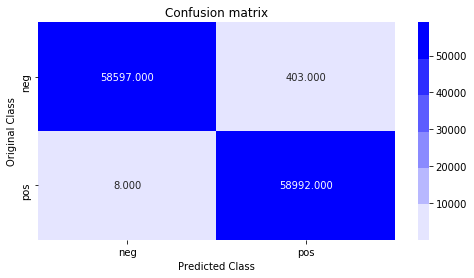

f1_score : 0.9965285696186494
Total Cost due to mis classifiation: 8030
Test Confusion Matrix


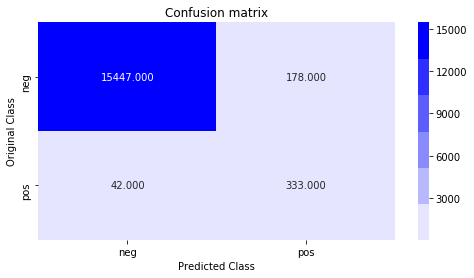

f1_score : 0.7516930022573363
Total Cost due to mis classifiation: 22780


In [48]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_constant, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

### Random Forest with mean

In [49]:
parameters = {"max_depth": [3,5,8,10] , "n_estimators":[100,300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

RF = RandomForestClassifier()
GCV = GridSearchCV(RF,param_grid=parameters, scoring = "f1", verbose = 1,cv=2,n_jobs = -1)
GCV.fit(X_train_mean_std , y_train_mean)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 30.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [50]:
clf_rf_mean= GCV.best_estimator_

In [51]:
GCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

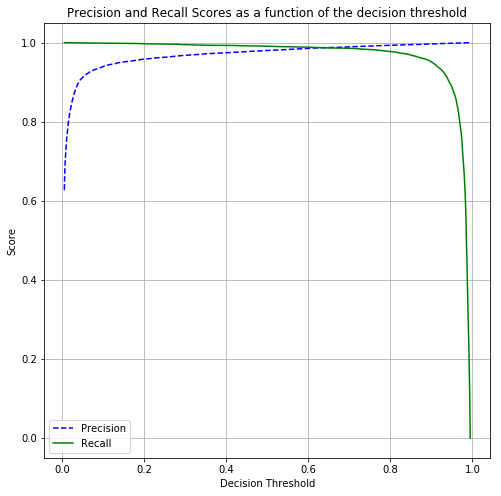

In [52]:
x_t, x_c, y_t, y_c = train_test_split(X_train_mean_std , y_train_mean, stratify=y_train_mean, test_size=0.3)
clf_rf_mean.fit(x_t, y_t)
sig_clf_probs = clf_rf_mean.predict_proba(x_c)[:,1]
#train_predict = clf.predict(x_train)
#cross_predict = clf.predict(x_test)
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [53]:
t=0.6

In [54]:
clf= GCV.best_estimator_
clf.fit(X_train_mean_std , y_train_mean)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
test_clf_probs = clf.predict_proba(X_test_mean_std)[:,1]
train_clf_probs = clf.predict_proba(X_train_mean_std)[:,1]

In [56]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


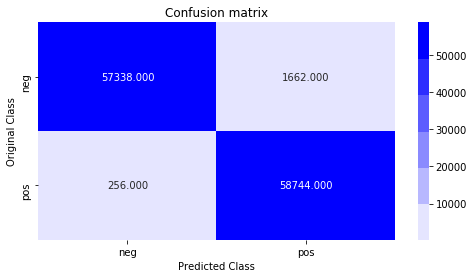

f1_score : 0.9839371555868214
Total Cost due to mis classifiation: 144620
Test Confusion Matrix


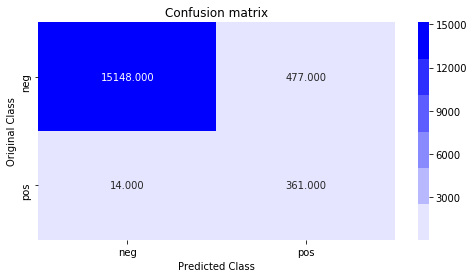

f1_score : 0.5952184666117064
Total Cost due to mis classifiation: 11770


In [57]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_constant, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

 <h2>Linear\logistic Regression with median</h2>

In [52]:
parameters = {"alpha": [10 ** x for x in range(-6, 3)], "penalty" : ['l2','l1'], "loss" : ['log','hinge']}

#Gridsearch CV with 8 fold crossvalidation

LR = SGDClassifier()    
GCV = GridSearchCV(LR,param_grid=parameters, scoring = "f1", verbose = 1,cv=8, n_jobs = -1)
GCV.fit(X_train_median_std , y_train_median )

Fitting 8 folds for each of 36 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  8.5min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100],
                         'loss': ['log', 'hinge'], 'penalty': ['l2', 'l1']},
 

In [53]:
clf_sgd_median= GCV.best_estimator_

In [54]:
GCV.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

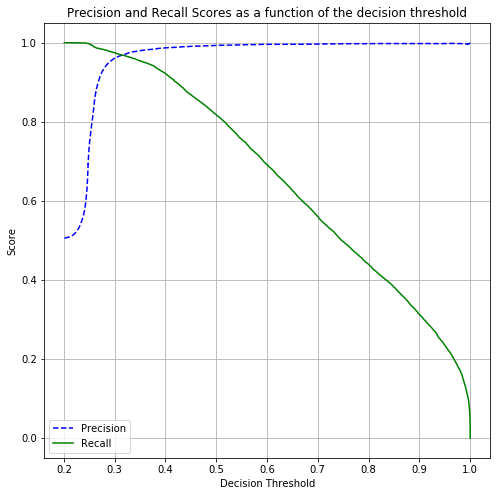

In [55]:
x_t, x_c, y_t, y_c = train_test_split(X_train_median_std , y_train_median, stratify=y_train_median, test_size=0.3)
clf_sgd_median.fit(x_t, y_t)
sig_clf = CalibratedClassifierCV(clf_sgd_median, method="sigmoid")
sig_clf.fit(x_t, y_t)
sig_clf_probs = sig_clf.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [56]:
t=0.32

In [57]:
clf= GCV.best_estimator_
clf.fit(X_train_median_std , y_train_median)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_median_std , y_train_median)
test_clf_probs = sig_clf.predict_proba(X_test_median_std)[:,1]
train_clf_probs = sig_clf.predict_proba(X_train_median_std)[:,1]

In [58]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


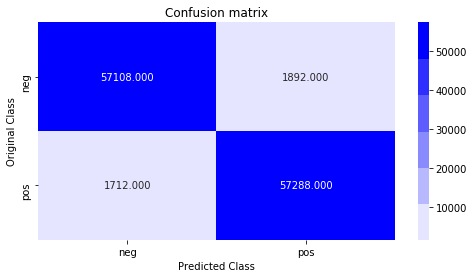

f1_score : 0.969504146217634
Total Cost due to mis classifiation: 874920
Test Confusion Matrix


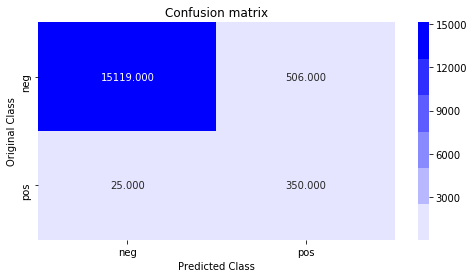

f1_score : 0.5686433793663689
Total Cost due to mis classifiation: 17560


In [59]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_median, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

### XGB with median

In [38]:
parameters = {"max_depth": [5,8,10] , "n_estimators":[300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

xgb = XGBClassifier()
GCV = GridSearchCV(xgb,param_grid=parameters, scoring = "f1", verbose = 1,cv=2,n_jobs = -1)
GCV.fit(X_train_median_std , y_train_median)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 181.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10],
                         'n_estimators': [300, 500, 1000, 2000]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [39]:
clf_xgb_median= GCV.best_estimator_

In [40]:
GCV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

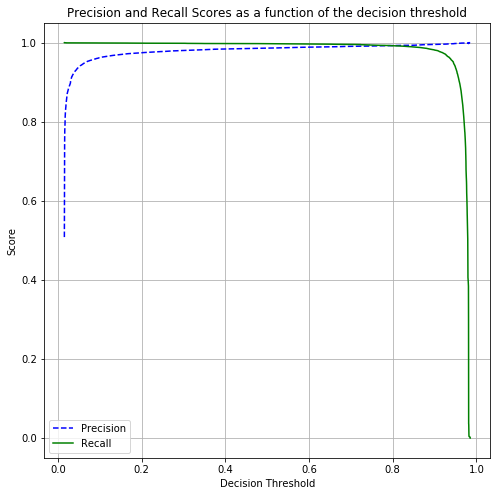

In [46]:
x_t, x_c, y_t, y_c = train_test_split(X_train_median_std, y_train_median, stratify=y_train_median, test_size=0.3)
clf_xgb_median.fit(x_t, y_t)
sig_clf_probs = clf_xgb_median.predict_proba(x_c)[:,1]
#train_predict = clf.predict(x_train)
#cross_predict = clf.predict(x_test)
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [47]:
t=0.8

In [48]:
clf_xgb_median.fit(X_train_median_std , y_train_median)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
test_clf_probs = clf_xgb_median.predict_proba(X_test_mean_std)[:,1]
train_clf_probs = clf_xgb_median.predict_proba(X_train_mean_std)[:,1]

In [50]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


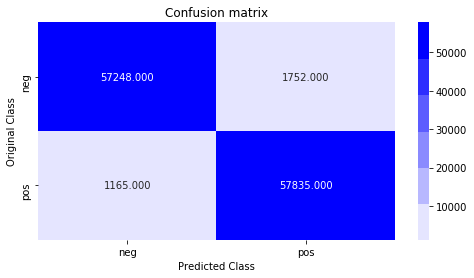

f1_score : 0.9754020255171308
Total Cost due to mis classifiation: 600020
Test Confusion Matrix


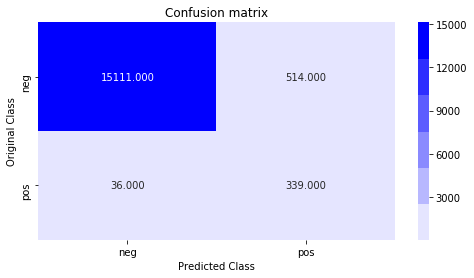

f1_score : 0.5521172638436482
Total Cost due to mis classifiation: 23140


In [51]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_median, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

# RandomForest with median

In [48]:
parameters = {"max_depth": [3,5,8,10] , "n_estimators":[100,300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

RF = RandomForestClassifier()
GCV = GridSearchCV(RF,param_grid=parameters, scoring = "f1", verbose = 1,cv=8, n_jobs = -1)
GCV.fit(X_train_median_std, y_train_median)

Fitting 8 folds for each of 20 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 80.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 635.4min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 8, 10], 'n_estimators': [100, 300, 500, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [49]:
clf_rf_median= GCV.best_estimator_

In [50]:
GCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

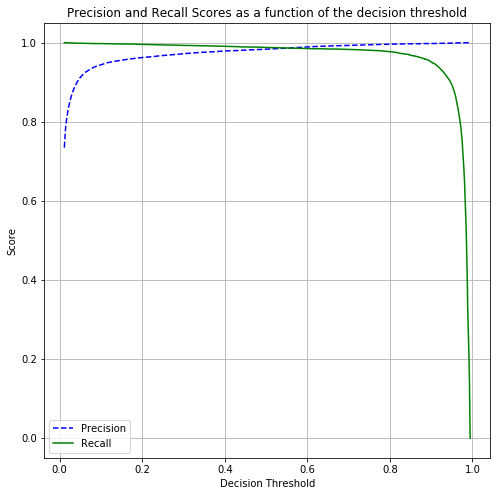

In [54]:
x_t, x_c, y_t, y_c = train_test_split(X_train_median_std, y_train_median, stratify=y_train_median, test_size=0.3)
clf_rf_median.fit(x_t, y_t)
sig_clf_probs = clf_rf_median.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [55]:
t=0.5

In [57]:
clf_rf_median.fit(X_train_median_std, y_train_median)
test_clf_probs = clf_rf_median.predict_proba(X_test_median_std)[:,1]
train_clf_probs = clf_rf_median.predict_proba(X_train_median_std)[:,1]

In [58]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


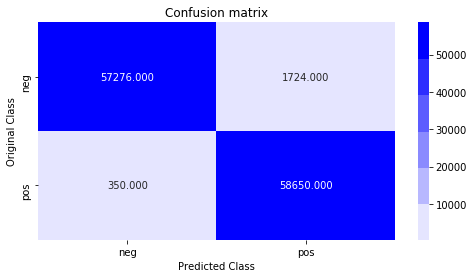

f1_score : 0.9826260324693818
Total Cost due to mis classifiation: 192240
Test Confusion Matrix


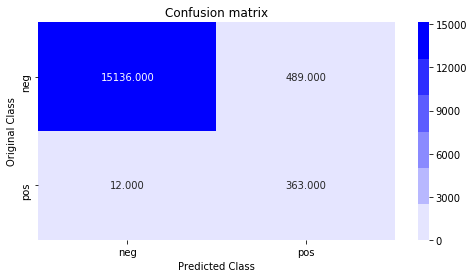

f1_score : 0.5916870415647921
Total Cost due to mis classifiation: 10890


In [60]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_median, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

 <h2>Linear\logistic Regression with constant value imputation</h2>

In [57]:
parameters = {"alpha": [10 ** x for x in range(-6, 3)], "penalty" : ['l2','l1'], "loss" : ['log','hinge']}

#Gridsearch CV with 8 fold crossvalidation

LR = SGDClassifier()    
GCV = GridSearchCV(LR,param_grid=parameters, scoring = "f1", verbose = 1,cv=8, n_jobs = -1)
GCV.fit(X_train_constant_std , y_train_constant )

Fitting 8 folds for each of 36 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  9.7min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100],
                         'loss': ['log', 'hinge'], 'penalty': ['l2', 'l1']},
 

In [58]:
clf_sgd_constant= GCV.best_estimator_

In [59]:
GCV.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

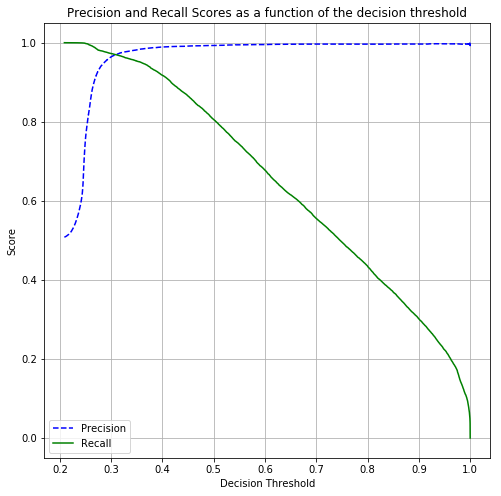

In [60]:
x_t, x_c, y_t, y_c = train_test_split(X_train_constant_std , y_train_constant, stratify=y_train_constant, test_size=0.3)
clf_sgd_constant.fit(x_t, y_t)
sig_clf = CalibratedClassifierCV(clf_sgd_constant, method="sigmoid")
sig_clf.fit(x_t, y_t)
sig_clf_probs = sig_clf.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [61]:
t=0.3

In [62]:
clf= GCV.best_estimator_
clf.fit(X_train_constant_std , y_train_constant)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_constant_std , y_train_constant)
test_clf_probs = sig_clf.predict_proba(X_test_constant_std)[:,1]
train_clf_probs = sig_clf.predict_proba(X_train_constant_std)[:,1]

In [63]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


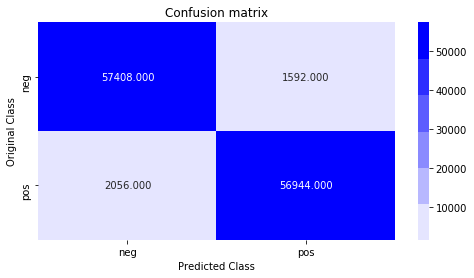

f1_score : 0.9689627007895454
Total Cost due to mis classifiation: 1043920
Test Confusion Matrix


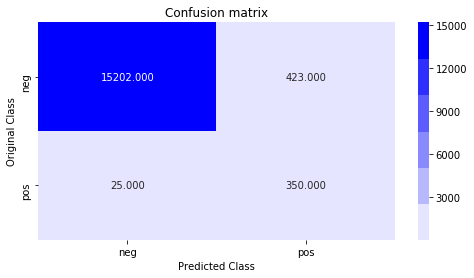

f1_score : 0.6097560975609756
Total Cost due to mis classifiation: 16730


In [64]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_constant, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

### XGB with constant value imputation

In [42]:
parameters = {"max_depth": [5,8,10] , "n_estimators":[300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

xgb = XGBClassifier()
GCV = GridSearchCV(xgb,param_grid=parameters, scoring = "f1", verbose = 1,cv=2,n_jobs = -1)
GCV.fit(X_train_constant_std , y_train_constant)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 131.2min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10],
                         'n_estimators': [300, 500, 1000, 2000]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [43]:
clf_xgb_constant= GCV.best_estimator_

In [44]:
GCV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [85]:
clf_xgb_constant = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

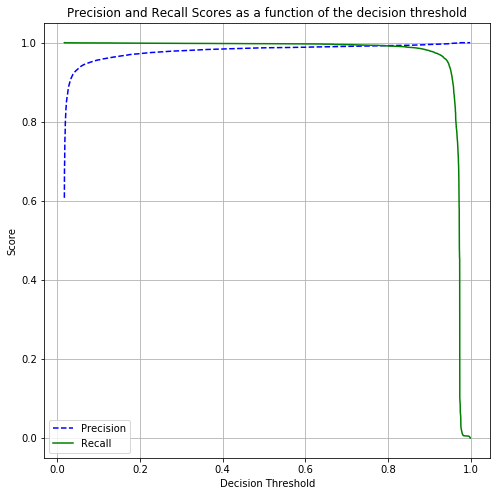

In [86]:
x_t, x_c, y_t, y_c = train_test_split(X_train_constant_std, y_train_constant, stratify=y_train_constant, test_size=0.3)
clf_xgb_constant.fit(x_t, y_t)
sig_clf_probs = clf_xgb_constant.predict_proba(x_c)[:,1]
#train_predict = clf.predict(x_train)
#cross_predict = clf.predict(x_test)
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [87]:
t=0.8

In [88]:
clf_xgb_constant.fit(X_train_constant_std , y_train_constant)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [89]:
test_clf_probs = clf_xgb_constant.predict_proba(X_test_constant_std)[:,1]
train_clf_probs = clf_xgb_constant.predict_proba(X_train_constant_std)[:,1]

In [90]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


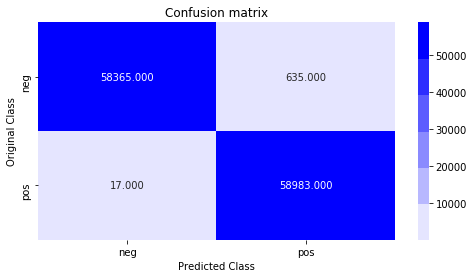

f1_score : 0.9945033637390615
Total Cost due to mis classifiation: 14850
Test Confusion Matrix


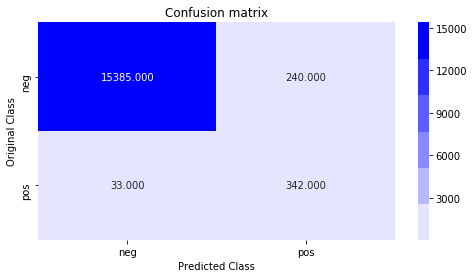

f1_score : 0.7147335423197493
Total Cost due to mis classifiation: 18900


In [91]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_constant, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

### Random Forest with constant value imputation

In [92]:
parameters = {"max_depth": [3,5,8,10] , "n_estimators":[100,300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

RF = RandomForestClassifier()
GCV = GridSearchCV(RF,param_grid=parameters, scoring = "f1", verbose = 1,cv=2,n_jobs =-1)
GCV.fit(X_train_constant_std , y_train_constant)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 30.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [93]:
clf_rf_constant= GCV.best_estimator_

In [94]:
GCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

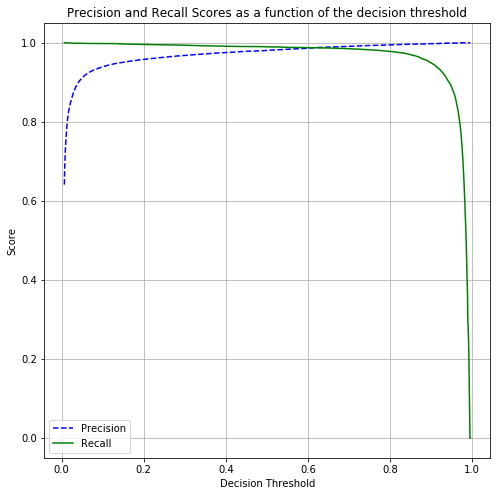

In [95]:
x_t, x_c, y_t, y_c = train_test_split(X_train_constant_std , y_train_constant, stratify=y_train_constant, test_size=0.3)
clf_rf_constant.fit(x_t, y_t)
sig_clf_probs = clf_rf_constant.predict_proba(x_c)[:,1]
#train_predict = clf.predict(x_train)
#cross_predict = clf.predict(x_test)
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [96]:
t=0.6

In [97]:
clf_rf_constant.fit(X_train_constant_std , y_train_constant)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
test_clf_probs = clf_rf_constant.predict_proba(X_test_constant_std)[:,1]
train_clf_probs = clf_rf_constant.predict_proba(X_train_constant_std)[:,1]

In [99]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


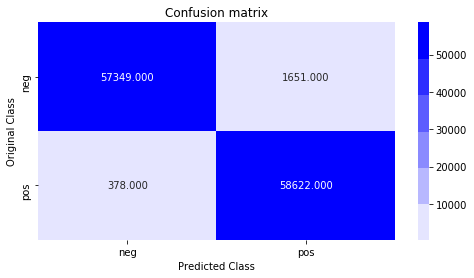

f1_score : 0.9829886059711753
Total Cost due to mis classifiation: 205510
Test Confusion Matrix


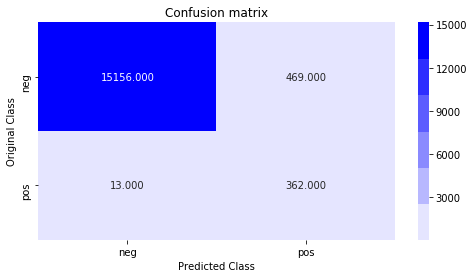

f1_score : 0.6003316749585407
Total Cost due to mis classifiation: 11190


In [100]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_constant, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

# Trying with dimensionality reduction techniques

* Random Forest classifier with medain value imputation given good results till now, so we will proceed with dimensionality reduction.

### PCA

In [68]:
pca = PCA()
train_pca = pca.fit(x_train_median)

In [69]:
explained_variance = pca.explained_variance_ratio_

In [70]:
explained_variance_sorted = np.sort(explained_variance)


In [71]:
length = len(explained_variance_sorted)

In [72]:
cumsum = pd.Series(explained_variance_sorted).cumsum()

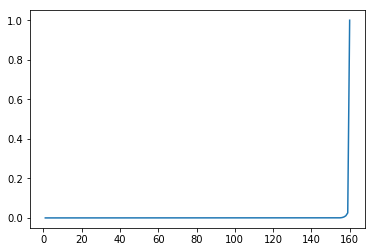

In [73]:
plt.plot(range(1,length+1),cumsum)
plt.show()

In [74]:
pca = PCA(n_components=20)
train_pca = pca.fit(x_train_median)

In [75]:
pca.explained_variance_ratio_.sum()

0.9999686390849858

In [76]:
x_train_median_pca = pca.transform(x_train_median)
x_test_median_pca = pca.transform(x_test_median)

In [77]:
sm = SMOTE(random_state=2)
X_train_median_sm_pca, y_train_median_pca = sm.fit_sample(x_train_median_pca, y_train.ravel())

In [78]:
ss = StandardScaler()
X_train_pca_std = ss.fit_transform(X_train_median_sm_pca)
X_test_pca_std = ss.transform(x_test_median_pca)

In [79]:
parameters = {"max_depth": [3,5,8,10] , "n_estimators":[100,300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

RF = RandomForestClassifier()
GCV = GridSearchCV(RF,param_grid=parameters, scoring = "f1", verbose = 1,cv=2, n_jobs = -1)
GCV.fit(X_train_pca_std, y_train_median_pca)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 15.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [80]:
clf_rf_pca= GCV.best_estimator_

In [81]:
GCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

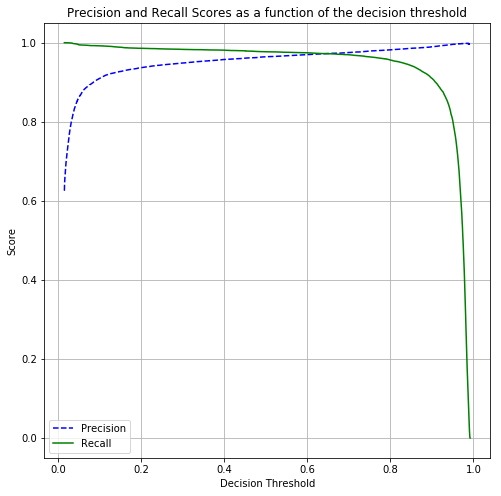

In [82]:
x_t, x_c, y_t, y_c = train_test_split(X_train_pca_std , y_train_median_pca, stratify=y_train_median_pca, test_size=0.3)
clf_rf_pca.fit(x_t, y_t)
sig_clf_probs = clf_rf_pca.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [83]:
t=0.6

In [84]:
clf_rf_pca.fit(X_train_pca_std , y_train_median_pca)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
test_clf_probs = clf_rf_pca.predict_proba(X_test_pca_std)[:,1]
train_clf_probs = clf_rf_pca.predict_proba(X_train_pca_std)[:,1]

In [86]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


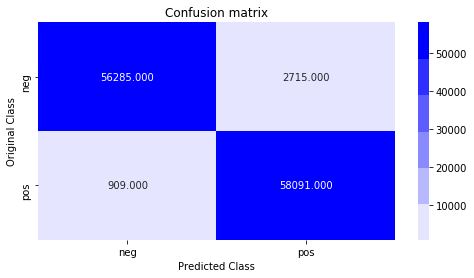

f1_score : 0.9697510976077992
Total Cost due to mis classifiation: 481650
Test Confusion Matrix


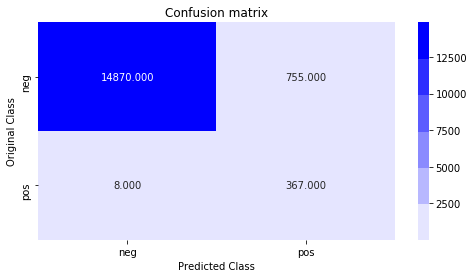

f1_score : 0.4903139612558451
Total Cost due to mis classifiation: 11550


In [87]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_median_pca, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

## SVD

In [69]:
from sklearn.decomposition import PCA, TruncatedSVD

In [94]:
# Taking 30 features
svd = TruncatedSVD(n_components=30)
train_svd = svd.fit(x_train_median)

In [95]:
svd.explained_variance_ratio_.sum()

0.9999854134465792

In [96]:
x_train_median_svd = svd.transform(x_train_median)
x_test_median_svd = svd.transform(x_test_median)

In [97]:
sm = SMOTE(random_state=2)
X_train_median_sm_svd, y_train_median_svd = sm.fit_sample(x_train_median_svd, y_train.ravel())

In [98]:
ss = StandardScaler()
X_train_svd_std = ss.fit_transform(X_train_median_sm_svd)
X_test_svd_std = ss.transform(x_test_median_svd)

In [99]:
parameters = {"max_depth": [3,5,8,10] , "n_estimators":[100,300,500,1000,2000]}


#Gridsearch CV with 2 fold crossvalidation

RF = RandomForestClassifier()
GCV = GridSearchCV(RF,param_grid=parameters, scoring = "f1", verbose = 1,cv=2, n_jobs = -1)
GCV.fit(X_train_svd_std, y_train_median_svd)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 34.9min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [100]:
clf_rf_svd= GCV.best_estimator_

In [101]:
GCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

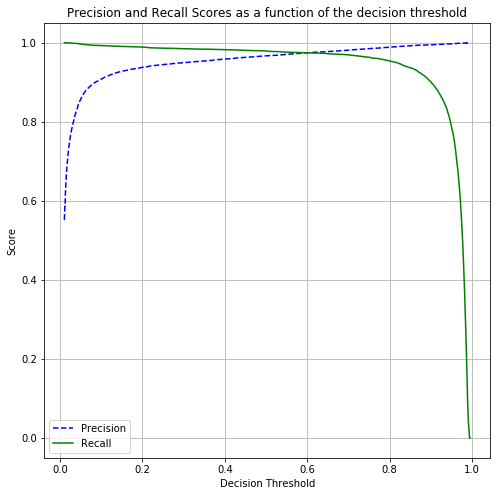

In [102]:
x_t, x_c, y_t, y_c = train_test_split(X_train_svd_std , y_train_median_svd, stratify=y_train_median_svd, test_size=0.3)
clf_rf_svd.fit(x_t, y_t)
sig_clf_probs = clf_rf_svd.predict_proba(x_c)[:,1]
presicision, recall, tresholds =precision_recall_curve(y_c,sig_clf_probs)
plot_precision_recall_vs_threshold(presicision, recall, tresholds)

In [104]:
clf_rf_svd.fit(X_train_svd_std , y_train_median_svd)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [106]:
test_clf_probs = clf_rf_svd.predict_proba(X_test_svd_std)[:,1]
train_clf_probs = clf_rf_svd.predict_proba(X_train_svd_std)[:,1]

In [134]:
# taking 0.4, since recall is high eith very little decrease in the precision
t=0.4

In [135]:
train_predictions = pred_with_threshold(train_clf_probs,t)
test_predictions = pred_with_threshold(test_clf_probs,t)

Train Confusion Matrix


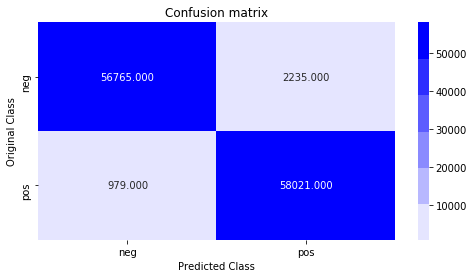

f1_score : 0.9730495740256255
Total Cost due to mis classifiation: 511850
Test Confusion Matrix


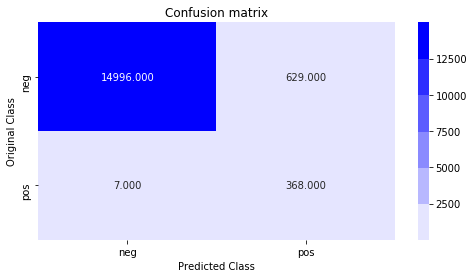

f1_score : 0.5364431486880467
Total Cost due to mis classifiation: 9790


In [136]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train_median_svd, train_predictions)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, test_predictions)

### Conclusions

In [132]:
from prettytable import PrettyTable

In [133]:
pt=PrettyTable()
pt.field_names=["model","imputation_method","f1-score","total_cost"]
pt.add_row(["sgd-hinge","Mean","0.59","13800"])
pt.add_row(["random_forest","Mean","0.60","11770"])
pt.add_row(["XGBoost","Mean","0.75","22780"])
pt.add_row(["sgd-hinge","Median","0.57","17560"])
pt.add_row(["random_forest","Median","0.59","10890"])
pt.add_row(["XGBoost","Median","0.55","23140"])
pt.add_row(["sgd-hinge","constant_value","0.60","16730"])
pt.add_row(["random_forest","constant_value","0.60","11190"])
pt.add_row(["XGBoost","constant_value","0.71","18900"])
pt.add_row(["PCA-0.6","constant_value","0.49","11550"])
pt.add_row(["svd-0.4","Median","0.53","9790"])
print(pt)

+---------------+-------------------+----------+------------+
|     model     | imputation_method | f1-score | total_cost |
+---------------+-------------------+----------+------------+
|   sgd-hinge   |        Mean       |   0.59   |   13800    |
| random_forest |        Mean       |   0.60   |   11770    |
|    XGBoost    |        Mean       |   0.75   |   22780    |
|   sgd-hinge   |       Median      |   0.57   |   17560    |
| random_forest |       Median      |   0.59   |   10890    |
|    XGBoost    |       Median      |   0.55   |   23140    |
|   sgd-hinge   |   constant_value  |   0.60   |   16730    |
| random_forest |   constant_value  |   0.60   |   11190    |
|    XGBoost    |   constant_value  |   0.71   |   18900    |
|    PCA-0.6    |   constant_value  |   0.49   |   11550    |
|    svd-0.4    |       Median      |   0.53   |    9790    |
+---------------+-------------------+----------+------------+


#### From the above results we coud conclude that, 
* Random forest classidier with median value imputation after applyind dimensionality reduction technique given good results.
* Many features are not important for the prediction, since out of 160 features, if we take 30 features we could able preserve  99.99% of varaince.
* So I have reduced the dimensions using SVD.
* with our best model we got the minimum cost of 9790.